**Social Sentiment and Stock Price Correlation**

See if the Apple stock price is correlated to the Twitter messages

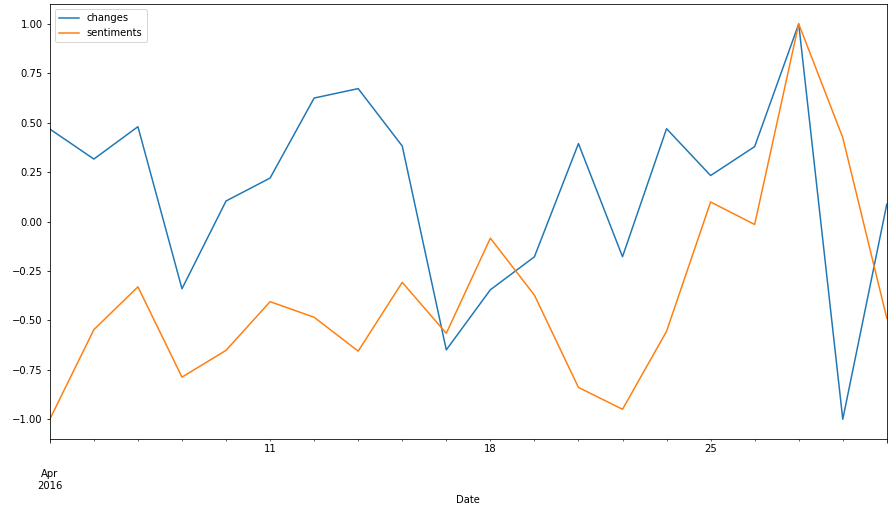



In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# TextBlob for Sentiment Analysis
from textblob import TextBlob

# For plotting word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
% matplotlib inline

pd.options.mode.chained_assignment = None
%load_ext google.colab.data_table 


# combine multiple words into one single word
# e.g. very good -> very_good
def combineWord(words):
  combined = ""
  for word in words:
    combined += word + "_"

  return combined[:len(combined)-1]


# get the sentiment polarity and assessment from Textblob
def getSentiments(content):
  tb = TextBlob(content)
  assessmentsList = []

  for assessments in tb.sentiment_assessments.assessments:
    assessmentsList.append((combineWord(assessments[0]), assessments[1]))

  return tb.polarity, assessmentsList


def getCount(countDict, word):
	if word in countDict:
		return countDict[word] + 1
	else:
		return 1


def plotWordCloud(freqDict, numWords):
  WIDTH, HEIGHT = 800, 600
  BG_COLOR = "black" # white

  wordcloud = WordCloud(max_words=numWords, stopwords='', width=WIDTH, height=HEIGHT, background_color=BG_COLOR).fit_words(freqDict)  
  plt.figure(figsize=[15,10])
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
# Sentiment analysis by TextBlob
# polarity is a float within the range [-1.0, 1.0] where -1 is very negative and 1.0 is very positive
# subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective
# Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information

sentence = 'This class is interesting'

print(sentence)
tb = TextBlob(sentence)
print('polarity=', tb.polarity)
print('subjectivity=', tb.subjectivity)

In [ ]:
# Textblob is rule and pattern based.
# https://planspace.org/20150607-textblob_sentiment/
# https://github.com/sloria/TextBlob/blob/eb08c120d364e908646731d60b4e4c6c1712ff63/textblob/en/en-sentiment.xml
# <word form="interesting" wordnet_id="a-01343918" pos="JJ" sense="arousing or holding the attention" polarity="0.5" subjectivity="0.5" intensity="1.0" confidence="0.9" />
# pos="JJ" (adjective)

tb.sentiment_assessments

In [ ]:
# Handle “modifier” such as "very"
# <word form="very" wordnet_id="r-00031899" pos="RB" sense="used as intensifier" polarity="0.2" subjectivity="0.3" intensity="1.3" confidence="0.9" />
# "very" intensity="1.3"
sentence = 'This class is very interesting'

print(sentence)
tb = TextBlob(sentence)
print('polarity=', tb.polarity)
tb.sentiment_assessments

In [ ]:
# Handle “negation” such as "not"
# self.negations   = kwargs.get("negations", ("no", "not", "n't", "never"))
sentence = 'This class is not interesting'

print(sentence)
tb = TextBlob(sentence)
print('polarity=', tb.polarity)
tb.sentiment_assessments

In [ ]:
# Handle mood (Emoticons)
# https://github.com/sloria/TextBlob/blob/dev/textblob/_text.py#L223
# ("smile", +0.50): set((">:)", ":-)", ":)", "=)", "=]", ":]", ":}", ":>", ":3", "8)", "8-)")),
sentence = 'oh :)'

print(sentence)
tb = TextBlob(sentence)
print('polarity=', tb.polarity)
tb.sentiment_assessments

In [ ]:
# Understand profanity (dirty word) 
# Don't understand punctuation (probably the punctuations are removed in the text pre-processing step)
print(TextBlob("he is a moron").sentiment_assessments)
print(TextBlob("who is the moron?").sentiment_assessments)

In [ ]:
# Averaging the sentiment scores for the overall polarity: "interesting" and "tough"
sentence = "This class is interesting but the content is too tough"

print(sentence)
tb = TextBlob(sentence)
print('polarity=', tb.polarity)
tb.sentiment_assessments

In [ ]:
# When a word (such as "mild") has different meaning in context, again use averaging
#<word form="mild" cornetto_synset_id="n_a-518871" wordnet_id="a-01893510" pos="JJ" sense="humble in spirit or manner" polarity="0.5" subjectivity="0.5" intensity="1.0" confidence="0.9" />
#<word form="mild" cornetto_synset_id="n_a-535263" wordnet_id="a-00438332" pos="JJ" sense="mild and pleasant" polarity="0.5" subjectivity="0.5" intensity="1.0" confidence="0.9" />
#<word form="mild" wordnet_id="a-01508719" pos="JJ" sense="moderate in type or degree or effect or force" polarity="0.0" subjectivity="0.5" intensity="1.0" confidence="0.9" />

sentence = 'The effect of the drug is mild'

print(sentence)
tb = TextBlob(sentence)
print('polarity=', tb.polarity)
tb.sentiment_assessments

In [ ]:
# Get the tweet data source
url = 'https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/appleTweets.xlsx'
appleTweets = pd.read_excel(url)

appleTweets.shape

In [ ]:
# Show partial results
appleTweets[:10]

In [ ]:
appleTweets.columns

In [ ]:
# Look at the subset of useful columns for the sentiment trading
COLUMNS = ['Date', 'User Name', 'Tweet content', 'Following', 'Hashtags']
appleTweetsSubset = appleTweets[COLUMNS]

appleTweetsSubset[:10]

In [ ]:
# Count Duplicates 
print('Duplicate content count=', appleTweetsSubset[['Tweet content']].duplicated().sum())

# Remove duplicate
print("Original row# :", appleTweetsSubset.shape[0])
appleTweetsSubset = appleTweetsSubset.drop_duplicates(subset='Tweet content', keep='first')
print("Row after removed duplicates# :", appleTweetsSubset.shape[0])

In [ ]:
# Filter the contents with the number of followings
MIN_FOLLOWING = 500

# Filter tweet with at least the MIN_FOLLOWING
appleTweetsFiltered = appleTweetsSubset[(appleTweetsSubset['Following'] >= MIN_FOLLOWING)]
appleTweetsFiltered.reset_index(drop=True, inplace=True)

print("Original row# :", appleTweetsSubset.shape[0])
print("Filtered row# :", appleTweetsFiltered.shape[0])

In [ ]:
# interactive table max_rows = 20000
SHOW_NUMS = 20000
appleTweetsFiltered[:SHOW_NUMS]

In [ ]:
# count the hastags frequencies
hashtagsCount = {}

for hashtags in appleTweetsFiltered['Hashtags']:
  if type(hashtags) == str:
    for hashtag in hashtags.split(","):
      tag = hashtag.strip().lower()
      hashtagsCount[tag] = getCount(hashtagsCount, tag)

hashtagsDf = pd.DataFrame.from_dict(hashtagsCount, orient='index', columns= ['count']).sort_values('count', ascending=False)
hashtagsDf

*   Use **TextBlob** to get the sentiment **assessment** and **polarity** of each Tweet content
*   Weight the tweets sentiment importance by the number of followings (**sentiment_weighted**)


In [ ]:
# Use TextBlob to run the tweets sentiment polarity
appleTweetsFiltered['sentiment'], appleTweetsFiltered['assessments'] = zip(*appleTweetsFiltered['Tweet content'].apply(getSentiments))

# Weight the tweets sentiment importance by the number of followings
appleTweetsFiltered['sentiment_weighted'] = appleTweetsFiltered['sentiment'] * appleTweetsFiltered['Following']

SENTIMENT_COLS = ['Tweet content', 'assessments', 'sentiment', 'Following', 'sentiment_weighted']
appleTweetsFiltered[SENTIMENT_COLS][:SHOW_NUMS]

In [ ]:
# see the sentiment distribution histogram
import plotly.express as px
fig = px.histogram(appleTweetsFiltered, x="sentiment", title='Sentiment Polarity Distribution', nbins=50)
fig.show()

In [ ]:
# Plot the sentiment_weighted
appleTweetsFiltered['sentiment_weighted'].plot(figsize=(12, 8))

In [ ]:
# count the positive, neutral and negative sentiment words
positiveWordCounts = {}
negativeWordCounts = {}
neutralWordCounts = {}
allWordsSentiment = {}

for assessments in appleTweetsFiltered['assessments']:
	for assessment in assessments:
		allWordsSentiment[assessment[0]] = assessment[1]
		
		if assessment[1] > 0:
			positiveWordCounts[assessment[0]] = getCount(positiveWordCounts, assessment[0])
		elif assessment[1] < 0:
			negativeWordCounts[assessment[0]] = getCount(negativeWordCounts, assessment[0])
		else:
			neutralWordCounts[assessment[0]] = getCount(neutralWordCounts, assessment[0])

In [ ]:
#Plot the positive WordCloud
plotWordCloud(positiveWordCounts, 100)

In [ ]:
#Plot the negative WordCloud
plotWordCloud(negativeWordCounts, 100)

In [ ]:
#Plot the neutral WordCloud
plotWordCloud(neutralWordCounts, 100)

In [ ]:
# use dataframe table to see all the sentiment poloarity and counts
allWordCountsDict = {**positiveWordCounts, **negativeWordCounts, **neutralWordCounts}
wordCountsDictDf = pd.DataFrame.from_dict(allWordCountsDict, orient='index', columns=['count'])
wordsSentimentDf = pd.DataFrame.from_dict(allWordsSentiment, orient='index', columns=['sentiment'])
allWordsDf = wordsSentimentDf.merge(wordCountsDictDf, left_index=True, right_index=True)
allWordsDf.sort_values(by=['count'], ascending=False)

In [ ]:
# Group the weighted sentiment by Date for matching the stock daily change

# Convert Date string to datetime to match with the stock daily change later
appleTweetsFiltered['Date'] = pd.to_datetime(appleTweetsFiltered['Date'])

aggregateSentiments = appleTweetsFiltered.groupby(['Date']).sum()[['sentiment_weighted']]
aggregateSentiments

In [ ]:
# get stocks daily data (OHLCV) from Yahoo finance
url = 'https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/appleStock201604.csv'
stock = pd.read_csv(url)
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock.set_index("Date")
stock

In [ ]:
# calculate the stock daily change
stock['change'] = (stock['Close'] - stock['Open']) / stock['Open']
stock[['Open', 'Close', 'change']]

In [ ]:
# Merge the daily stock price change with the sentiments
# Use the daily aggregated sentiment to predict the daily price change
merged = stock.merge(aggregateSentiments, on='Date', how='left')[['change', 'sentiment_weighted']]
merged

In [ ]:
# Scale the unit to -1 to 1
scaler = MinMaxScaler((-1, 1))
merged['changes'] = scaler.fit_transform(merged[['change']])
merged['sentiments'] = scaler.fit_transform(merged[['sentiment_weighted']])
scaled = merged[['changes', 'sentiments']]
scaled

In [ ]:
scaled.plot(figsize=(15, 8))

In [ ]:
# shows the correlation
scaled.corr()

 **Try sentiments with different date lags**

*   Sentiment shift backwards -> Current day sentiments predicts next day stock price change (**predictive_sentiment**)
*   Sentiment shift forwards -> Current day sentiments reflects yesterday's price change (**reactive_sentiment**)


In [ ]:
# Sentiment shift backwards -> Current day sentiments predicts next day stock price change (predictive)
scaled['predictive_sentiment'] = merged['sentiments'].shift(-1)

# Sentiment shift forwards -> Current day sentiments reflects yesterday's price change (reactive)
scaled['reactive_sentiment'] = merged['sentiments'].shift(1)
scaled

In [ ]:
scaled.corr()

**Notes**
* **Filter contents** with different conditions or use hashtags to get more "relevant" tweets to the company
* Use different **weightings** apart from the Followings
* Take sentiment **subjectivity** into account (maybe more subjective is more important)
* Is the **coverage** enough? Add different data source of sentiment
* Use a better **sentiment analysis engine** (e.g. tailored made with social media content and stock trading)
* Try with **different date lags** and compares the close price changes rather than open-close changes
* Price change comparing to **sentiment change** rather than raw sentiment scores
* Use sentiment **moving average** or long/short term sentiment cross over
* Combine with other **technical indicators** such as stock price moving average
* Combine with other Machine Learned **signals** or trends